# Image Deconvolution using Variational Method

This numerical tour explores the use of
Sobolev and TV regularization to perform image deconvolution.

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


In [2]:
using PyPlot
using NtToolBox
# using Autoreload
# arequire("NtToolBox")

This tour is concerned with the deconvolution problem. The measurement
are assumed to be blurry and noisy:
 $$y=\Phi f_0 + w = h \star f_0 + w$$



Where here |h| is the filter (low pass) and |w| some noise (here assumed
to be white Gaussian).


We consider variational deconvolution methods, that finds a regularizer
through a convex optimization:
 $$f^\star \in \text{argmin}_f \frac{1}{2}\|y-\Phi f\|^2 + \lambda J(f)$$



Where $J(f)$ is a prior energy. In this tour we consider a simple L2
prior (the image is assumed to have a bounded energy), a Sobolev prior
(the image is uniformly smooth) and an approximate total variation (the
image has edges of bounded perimeter).


Note that the parameter $\lambda$ should be carefully chosen to fit the
noise level.

## Image Blurring

Deconvolution corresponds to removing a blur from an image.
We use here a Gaussian blur.


First we load the image to be inpainted.

In [3]:
n = 256
name = "NtToolBox/src/data/hibiscus.png"
f0 = load_image(name, n);

Initial image $f_0$.

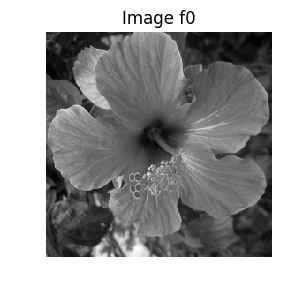

PyObject <matplotlib.text.Text object at 0x326743a50>

In [4]:
imageplot(f0, "Image f0", [1, 2, 1])

We build a convolution kernel.
Since we are going to use Fourier to compute the convolution,
we set the center of the kernel in the (1,1) pixel location.

Width $s$ of the kernel, in pixel.

In [5]:
s = 3;

Define the convolution kernel $h$.

In [6]:
include("NtToolBox/src/ndgrid.jl")
x = [collect(0:n/2 - 1); collect(-n/2:-1)]
(Y, X) = meshgrid(x, x)
h = exp((-X.^2 - Y.^2)/(2*s^2))
h = h/sum(h);

Useful for later : the Fourier transform (should be real because of symmetry).

In [6]:
hF = real(plan_fft(h)*h);

256×256 Array{Float64,2}:
 1.0       0.997293  0.989216  0.975898  …  0.975898  0.989216  0.997293
 0.997293  0.994593  0.986538  0.973256     0.973256  0.986538  0.994593
 0.989216  0.986538  0.978547  0.965374     0.965374  0.978547  0.986538
 0.975898  0.973256  0.965374  0.952377     0.952377  0.965374  0.973256
 0.957555  0.954963  0.947228  0.934476     0.934476  0.947228  0.954963
 0.934476  0.931946  0.924398  0.911954  …  0.911954  0.924398  0.931946
 0.907023  0.904567  0.897241  0.885162     0.885162  0.897241  0.904567
 0.875616  0.873246  0.866173  0.854512     0.854512  0.866173  0.873246
 0.840726  0.83845   0.831659  0.820463     0.820463  0.831659  0.83845 
 0.802862  0.800689  0.794204  0.783512     0.783512  0.794204  0.800689
 0.762558  0.760494  0.754334  0.744179  …  0.744179  0.754334  0.760494
 0.720361  0.718411  0.712592  0.702999     0.702999  0.712592  0.718411
 0.67682   0.674987  0.66952   0.660507     0.660507  0.66952   0.674987
 ⋮                       

Display the kernel and its transform.
We use |fftshift| to center the filter for display.

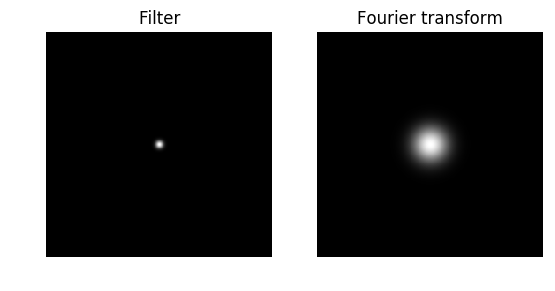

PyObject <matplotlib.text.Text object at 0x000000001DAD18D0>

In [7]:
imageplot(fftshift(h), "Filter", [1, 2, 1])
imageplot(fftshift(hF), "Fourier transform", [1, 2, 2])

We use this short hand for the filtering.
Note that this is a symmetric operator.

In [8]:
Phi = (x, h) -> real(plan_ifft((plan_fft(x)*x) .* (plan_fft(h)*h))*((plan_fft(x)*x) .* (plan_fft(h)*h)))

(::#3) (generic function with 1 method)

*Important* Scilab user should define a function |Phi| in a separate file |Phi.sci|
to perform this.


Apply the filter.

In [9]:
y0 = Phi(f0, h);

256×256 Array{Float64,2}:
 0.147006  0.164445  0.178005  0.187653  …  0.0906591  0.107472   0.127165
 0.138294  0.156249  0.170627  0.181218     0.0822509  0.0987673  0.118306
 0.132873  0.151598  0.166987  0.178637     0.0760766  0.0926947  0.112434
 0.131464  0.151143  0.167608  0.180264     0.0728161  0.0899615  0.110277
 0.133701  0.154393  0.171868  0.185341     0.0725241  0.0904672  0.111599
 0.138475  0.160082  0.17837   0.192364  …  0.0747425  0.0935097  0.11548 
 0.144456  0.166724  0.185502  0.199624     0.0787502  0.098146   0.12077 
 0.150461  0.172999  0.191824  0.205601     0.0837858  0.103476   0.126429
 0.155538  0.177844  0.196176  0.20908      0.0891548  0.108739   0.131609
 0.158878  0.180365  0.197607  0.209119     0.0942428  0.113281   0.135589
 0.159786  0.179831  0.195408  0.205105  …  0.0985227  0.116535   0.137736
 0.157835  0.17587   0.189329  0.196972     0.101614   0.118099   0.137626
 0.153118  0.168747  0.179862  0.185461     0.103376   0.117879   0.135232

Display the filtered observation.

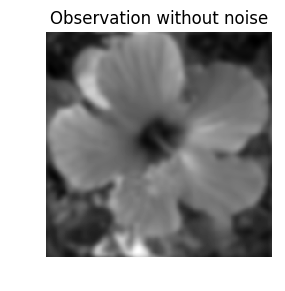

PyObject <matplotlib.text.Text object at 0x000000001EB40CC0>

In [10]:
imageplot(y0, "Observation without noise", [1, 2, 2])

Variance $\sigma^2$ of the noise $w$.

In [11]:
sigma = .02;

0.02

Add some noise to obtain the measurements $y = \Phi f_0 + w$.

In [12]:
y = y0 .+ randn(n, n).*sigma;

256×256 Array{Float64,2}:
 0.187654   0.185974  0.195066  0.189263  …  0.10219    0.0918291  0.116488 
 0.0948482  0.164217  0.154785  0.205916     0.114538   0.0904093  0.121988 
 0.109873   0.151707  0.152401  0.174968     0.0855326  0.107687   0.123125 
 0.143554   0.127152  0.145506  0.202726     0.0730925  0.0606067  0.11371  
 0.140267   0.162569  0.12932   0.216793     0.0631901  0.0337215  0.0986603
 0.115588   0.177814  0.179761  0.207952  …  0.0853762  0.116003   0.112846 
 0.109074   0.185258  0.207259  0.168357     0.0715336  0.101621   0.128139 
 0.1629     0.186155  0.178142  0.204365     0.0927259  0.11247    0.159682 
 0.188056   0.179991  0.196923  0.204523     0.0847032  0.0837348  0.142779 
 0.152072   0.189626  0.251811  0.183494     0.0361014  0.0995018  0.162877 
 0.161646   0.158808  0.189759  0.200411  …  0.0688726  0.104941   0.135166 
 0.18464    0.179556  0.19524   0.191587     0.100401   0.145377   0.141307 
 0.149682   0.151738  0.186778  0.19889      0.104

Display.

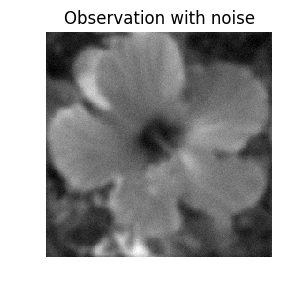

PyObject <matplotlib.text.Text object at 0x000000001ED8D2E8>

In [13]:
imageplot(clamP(y), "Observation with noise", [1, 2, 2])

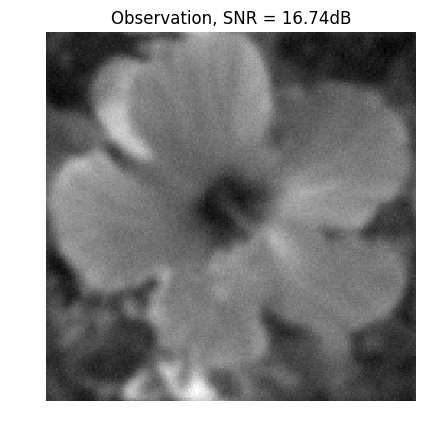

PyObject <matplotlib.text.Text object at 0x000000001EFE0EF0>

In [14]:
imageplot(y, string("Observation, SNR = ", string(round(snr(f0, y),2)), "dB"))

## Deconvolution with L2 Regularization

Deconvolution is obtained by dividing the Fourier transform of $y$
by $\hat h$.
 $$f^\star(\omega) = \frac{\hat y(\omega)}{\hat h(\omega)} = \hat f_0(\omega) + \hat w(\omega)/{\hat h(\omega)}$$


Unfortunately this creates an explosion of the Noise.


To avoid this explosion, we consider a simple regularization.
 $$f^{\star} = \text{argmin}_f \: \|y-\Phi f\|^2 + \lambda \|f\|^2$$



Since the filtering is diagonalized over Fourier, the solution is simply
computed over the Fourier domain as:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda }$$



Useful for later: Fourier transform of the observations.

In [15]:
yF = plan_fft(y)*y;

256×256 Array{Complex{Float64},2}:
  23959.6+0.0im         -2143.98-880.931im  …     -2143.98+880.931im
 -2229.31-216.21im      -2522.91-1518.67im        -1420.11+682.078im
 -997.392-22.7833im     -203.708+500.58im          426.197+1008.44im
  327.986+392.848im     -119.196-345.563im        -222.064-48.2954im
 -84.1553+594.889im      54.5129+162.707im         348.778+164.008im
  341.862+194.015im      254.462-18.3943im  …      122.646-71.5433im
 -118.367+375.152im      114.547+158.468im        -319.528+64.7372im
 -96.1416+209.634im      296.944+220.954im        -314.014+55.2186im
  95.7686+199.581im      33.0256+1.18373im         2.73406+86.182im 
 -25.4992+154.863im      75.9527-159.491im        -105.829+76.8562im
 -103.789+201.114im  -0.00158153+79.6004im  …     -78.2486+4.80056im
 -140.109+49.5548im      -81.907-23.7371im        -14.7995-4.43073im
  102.193+2.29866im      64.3186-7.02616im         19.1352-125.278im
         ⋮                                  ⋱             ⋮         

Select a value for the regularization parameter.

In [16]:
Lambda = 0.02;

0.02

Perform the inversion.

In [17]:
fL2 = real(plan_ifft((yF .* hF ./ (abs(hF).^2 .+ Lambda)))*((yF .* hF ./ (abs(hF).^2 .+ Lambda))));

256×256 Array{Float64,2}:
 0.162544  0.179298  0.184509  0.182516  …  0.0698412   0.101146   0.134711 
 0.135278  0.157158  0.169893  0.175841     0.0451367   0.0734671  0.105721 
 0.113034  0.140381  0.160654  0.174409     0.0224082   0.0489482  0.0809874
 0.10342   0.135526  0.161482  0.180579     0.00818441  0.0348732  0.0682827
 0.109804  0.145305  0.174012  0.194632     0.00625252  0.034968   0.0712569
 0.129587  0.167085  0.195777  0.214339  …  0.0157824   0.0475732  0.0876302
 0.155517  0.194114  0.221244  0.235814     0.0319167   0.066651   0.110449 
 0.179103  0.218471  0.244     0.254771     0.0485613   0.085039   0.131588 
 0.194054  0.233982  0.258777  0.267442     0.0615229   0.0978598  0.145318 
 0.197972  0.237758  0.262571  0.271061     0.0699496   0.104023   0.149942 
 0.191946  0.230142  0.254865  0.264238  …  0.0754737   0.105323   0.147066 
 0.178988  0.213717  0.237333  0.247373     0.0802253   0.104373   0.139668 
 0.162592  0.192233  0.213362  0.222933     0.0853

Display.

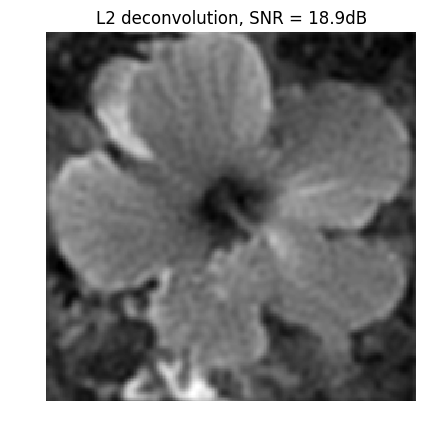

PyObject <matplotlib.text.Text object at 0x0000000026C12400>

In [18]:
imageplot(clamP(fL2), string("L2 deconvolution, SNR = ", string(round(snr(f0, fL2), 2)), "dB"))

**Exercise 1:** Find the optimal solution fL2 by testing several value of $\lambda$.

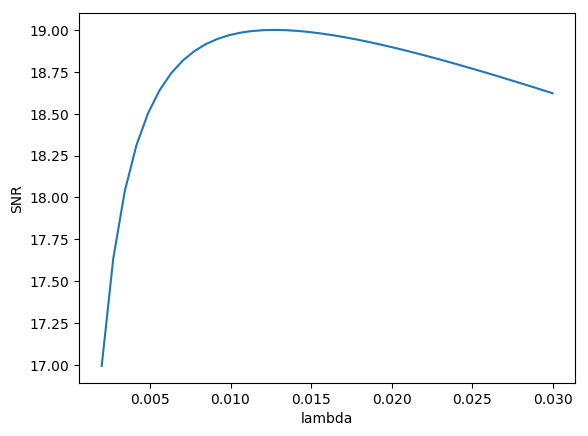

256×256 Array{Float64,2}:
 0.172828   0.188661  0.189746  …   0.0698061    0.104854   0.142608 
 0.139417   0.161483  0.172343      0.0424529    0.0728089  0.107817 
 0.11129    0.13975   0.160133      0.0165905    0.0438522  0.077498 
 0.0987255  0.132439  0.159574      0.000476029  0.0274102  0.0619509
 0.106348   0.143443  0.17319      -0.00108197   0.0282633  0.0659985
 0.130656   0.169416  0.198056  …   0.0106395    0.0439784  0.0864246
 0.161938   0.20154   0.227281      0.0291259    0.0663883  0.113822 
 0.189174   0.229719  0.253056      0.046588     0.0862457  0.137617 
 0.204775   0.246547  0.269297      0.0583074    0.0979514  0.151021 
 0.206657   0.24916   0.272889      0.0643789    0.101348   0.153009 
 0.197225   0.238765  0.263663  …   0.0680819    0.0999811  0.146821 
 0.180859   0.218998  0.243811      0.0727651    0.0978384  0.136891 
 0.161877   0.19444   0.217286      0.0797671    0.097142   0.126597 
 ⋮                              ⋱                           ⋮   

In [19]:
include("NtSolutions/inverse_2_deconvolution_variational/exo1.jl")

Display optimal result.

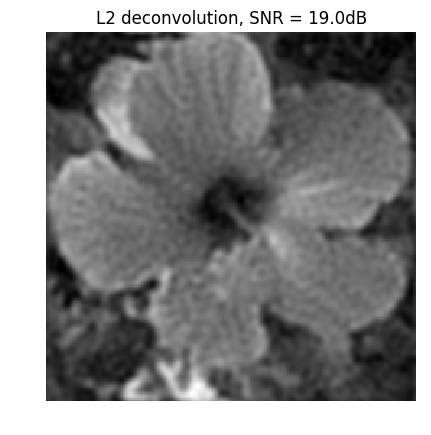

PyObject <matplotlib.text.Text object at 0x0000000026FE78D0>

In [20]:
imageplot(clamP(fL2), string("L2 deconvolution, SNR = ", string(round(snr(f0, fL2), 2)), "dB") )

## Deconvolution by Sobolev Regularization.

L2 regularization did not perform any denoising. To remove some noise, we
can penalize high frequencies using Sobolev regularization (quadratic
grow).


The Sobolev prior reads (note the conversion from spacial domain to
Fourier domain)
 $$J(f) = \sum_x \|\nabla f(x)\|^2 = \sum_{\omega} S(\omega) \|\hat f(\omega)\|^2 $$
where $S(\omega)=\|\omega\|^2$.





Since this prior can be written over the Fourier domain, one can compute
the solution to the deblurring with Sobolev prior simply with the Fourier
coefficients:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda S(\omega) }$$




Compute the Sobolev prior penalty |S|(rescale to [0,1]).

In [21]:
S = (X.^2 + Y.^2) .* (2/n).^2;

256×256 Array{Float64,2}:
 0.0          6.10352e-5   0.000244141  …  0.000244141  6.10352e-5 
 6.10352e-5   0.00012207   0.000305176     0.000305176  0.00012207 
 0.000244141  0.000305176  0.000488281     0.000488281  0.000305176
 0.000549316  0.000610352  0.000793457     0.000793457  0.000610352
 0.000976563  0.0010376    0.0012207       0.0012207    0.0010376  
 0.00152588   0.00158691   0.00177002   …  0.00177002   0.00158691 
 0.00219727   0.0022583    0.00244141      0.00244141   0.0022583  
 0.00299072   0.00305176   0.00323486      0.00323486   0.00305176 
 0.00390625   0.00396729   0.00415039      0.00415039   0.00396729 
 0.00494385   0.00500488   0.00518799      0.00518799   0.00500488 
 0.00610352   0.00616455   0.00634766   …  0.00634766   0.00616455 
 0.00738525   0.00744629   0.00762939      0.00762939   0.00744629 
 0.00878906   0.0088501    0.0090332       0.0090332    0.0088501  
 ⋮                                      ⋱               ⋮          
 0.00878906   0.008850

Regularization parameter:

In [22]:
Lambda = 0.2;

0.2

Perform the inversion.

In [23]:
fSob = real(plan_ifft((yF .* hF ./ (abs(hF).^2 .+ Lambda.*S)))*((yF .* hF ./ (abs(hF).^2 .+ Lambda.*S))));

256×256 Array{Float64,2}:
 0.175639  0.19019   0.189784  0.181096  …   0.0709781   0.107597   0.145925 
 0.142296  0.163247  0.172283  0.17375       0.04087     0.0736867  0.110397 
 0.114817  0.142669  0.161192  0.172556      0.012912    0.0433002  0.0797346
 0.102337  0.13616   0.161862  0.180008     -0.00453659  0.025591   0.0634812
 0.10899   0.147008  0.176298  0.196541     -0.00673413  0.0252544  0.0661898
 0.13184   0.172287  0.201825  0.219858  …   0.00520149  0.040325   0.0852486
 0.162261  0.204053  0.232024  0.245588      0.0250944   0.0633587  0.112266 
 0.189869  0.232701  0.25916   0.268613      0.0451309   0.0853097  0.137162 
 0.206721  0.25054   0.276711  0.28428       0.0597676   0.0997531  0.152552 
 0.20969   0.253931  0.280955  0.289184      0.0677859   0.105067   0.156083 
 0.200318  0.243476  0.271401  0.281705  …   0.071598    0.103755   0.149966 
 0.182984  0.222846  0.250421  0.262465      0.0747898   0.0999625  0.138687 
 0.162767  0.197208  0.222495  0.23459

Display the result.

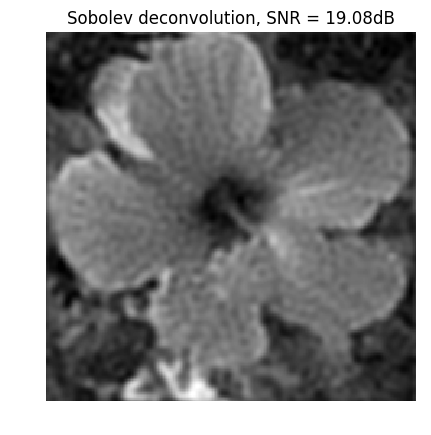

PyObject <matplotlib.text.Text object at 0x0000000026ED0470>

In [24]:
imageplot(clamP(fSob), string("Sobolev deconvolution, SNR = ", string( round(snr(f0, fSob), 2) ), "dB") )

**Exercise 2:** Find the optimal solution fSob by testing several value of
$\lambda$.

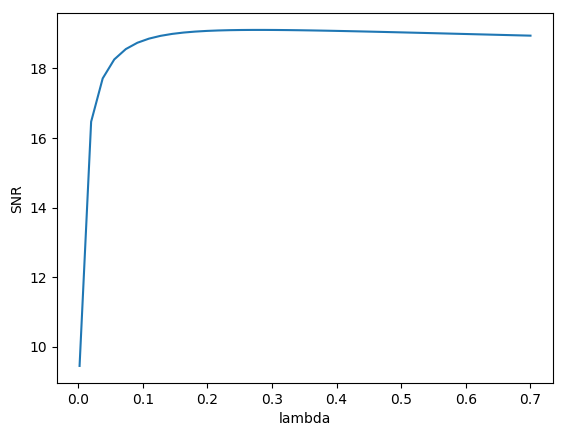

256×256 Array{Float64,2}:
 0.16994   0.185339  0.187795  0.182789  …   0.0713346   0.105698   0.141525 
 0.139974  0.16114   0.171741  0.175358      0.0426857   0.0742002  0.109195 
 0.115693  0.143219  0.162171  0.174281      0.0164528   0.0462581  0.0815925
 0.104836  0.138064  0.1636    0.181721     -2.78932e-5  0.0298136  0.0668898
 0.11087   0.148349  0.177575  0.197901     -0.00259494  0.0289657  0.0689966
 0.131322  0.171491  0.201608  0.220568  …   0.00791182  0.0421771  0.0857983
 0.158885  0.200628  0.229951  0.245543      0.0262935   0.0632087  0.110251 
 0.18459   0.227347  0.255614  0.267878      0.0457598   0.0842433  0.133678 
 0.201274  0.244669  0.272532  0.282996      0.0611486   0.0993629  0.149371 
 0.205678  0.248963  0.277046  0.287538      0.0707465   0.106488   0.154666 
 0.198563  0.240304  0.268435  0.279956  …   0.0759476   0.107074   0.150807 
 0.183394  0.221668  0.248715  0.260946      0.0794449   0.104291   0.141283 
 0.164637  0.197656  0.222     0.23358

In [25]:
include("NtSolutions/inverse_2_deconvolution_variational/exo2.jl")

Display optimal result.

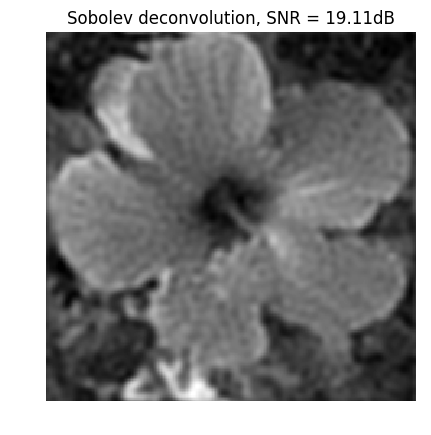

PyObject <matplotlib.text.Text object at 0x0000000027733CC0>

In [26]:
imageplot(clamP(fSob), string("Sobolev deconvolution, SNR = ", string( round(snr(f0, fSob), 2) ), "dB") )

## Deconvolution by Total Variation Regularization

Sobolev regularization perform a denoising but also tends to blur the
edges, thus producing a poor results on cartoon images.


The TV prior is able to better reconstruct sharp edges. It reads:
 $$J(f) = \sum_x \| \nabla f(x)\|$$



With respect to the Sobolev energy, it simply corresponding to measuring
the L1 norm instead of the L2 norm, thus dropping the square in the
functional.


Unfortunately, the TV functional $J(f)$ is not a smooth function of the image
$f$. It thus requires the use of advanced convex optimization method to
be minimized for regularization.


An alternative is to replace the absolute value by a smooth absolute value.
The smoothed TV norm reads:
 $$J(f) = \sum_x \sqrt{\|\nabla f(x)\|^2+\varepsilon^2}$$



Regularization parameter for the TV norm:

In [27]:
epsilon = 0.4*1e-2;

0.004

When $\epsilon$ gets close to zero, the smoothed energy becomes closer to
the original total variation, but the optimization becomes more
difficult. When |epsilon| becomes large, the smoothed energy becomes
closer to the Sobolev energy, thus blurring the edges.


Unfortunately, this prior is non-quadratic, and cannot be expressed over
the Fourier domain. One thus need to use an iterative scheme such as a
gradient descent to approximate the solution.


An iteration of the gradient descent reads:
 $$f^{(k+1)} = f^{(k)} - \tau \left( h \star (h \star f^{(k)} - y) +  \lambda \text{Grad} J(f^{(k)})  \right)$$



Regularization parameter.

In [28]:
Lambda = 0.06;

0.06

The value of $\tau$, the step size, should be smaller than twice the
Lipschitz constant of the Gradient of the functional to be minimized,
hence:
$$ \tau< \frac{2}{1 + \lambda 8/\varepsilon }.$$

In [29]:
tau = 1.9 / (1 + Lambda * 8 / epsilon);

0.015702479338842973

Initialization.

In [30]:
fTV = y;

256×256 Array{Float64,2}:
 0.187654   0.185974  0.195066  0.189263  …  0.10219    0.0918291  0.116488 
 0.0948482  0.164217  0.154785  0.205916     0.114538   0.0904093  0.121988 
 0.109873   0.151707  0.152401  0.174968     0.0855326  0.107687   0.123125 
 0.143554   0.127152  0.145506  0.202726     0.0730925  0.0606067  0.11371  
 0.140267   0.162569  0.12932   0.216793     0.0631901  0.0337215  0.0986603
 0.115588   0.177814  0.179761  0.207952  …  0.0853762  0.116003   0.112846 
 0.109074   0.185258  0.207259  0.168357     0.0715336  0.101621   0.128139 
 0.1629     0.186155  0.178142  0.204365     0.0927259  0.11247    0.159682 
 0.188056   0.179991  0.196923  0.204523     0.0847032  0.0837348  0.142779 
 0.152072   0.189626  0.251811  0.183494     0.0361014  0.0995018  0.162877 
 0.161646   0.158808  0.189759  0.200411  …  0.0688726  0.104941   0.135166 
 0.18464    0.179556  0.19524   0.191587     0.100401   0.145377   0.141307 
 0.149682   0.151738  0.186778  0.19889      0.104

Number of iteration (quite a large number is required).

In [31]:
niter = 300;

300

We first check that the discretized grad and -div are adjoint one of each other.

In [32]:
a = rand(n,n)
b = rand(n, n, 2)
dotp = (x, y) -> sum(x[:].*y[:])
print(string("Should be 0: ", string(dotp(grad(a),b) + dotp(a, NtToolBox.div(b)))) ) #We use NtToolBox.div instead of div because otherwise there will be a conflict with the function div of package Base.

Should be 0: 8.881784197001252e-14

The gradient of the smoothed TV energy is:
 $$\text{Grad} J(f) = -\text{div}\left( \frac{\nabla f}{ \sqrt{\|\nabla f\|^2+\varepsilon^2} } \right)$$



Compute the gradient of the smoothed TV functional.

In [33]:
repeat3 = x -> cat(3, x, x)
Gr = grad(fTV)
d = sqrt(epsilon^2 .+ sum(Gr.^2, 3))[:, :]
G = -NtToolBox.div(Gr ./ repeat3(d) ); #We use NtToolBox.div instead of div because otherwise there will be a conflict with the function div of package Base.

256×256 Array{Float64,2}:
  2.87749     0.783655     0.710026  …   0.818071   -2.06849    -1.07732  
 -3.17451     1.4231      -2.51781       3.13648    -2.04166     1.89589  
 -1.98244     0.961861    -0.673399     -0.248911    1.97498     1.70595  
  2.65669    -3.28147     -0.518768      1.53404    -2.14657    -0.111665 
  0.822426    2.03843     -2.53996      -1.18063    -2.64839    -1.092    
 -1.45436     0.323938    -0.683185  …   0.670577    2.83874    -1.00964  
 -2.01063     0.651183     3.07285      -0.806229   -1.42148     1.53331  
 -0.644908    2.01831     -2.71889       0.620902    0.95215     2.47747  
  2.82791    -2.12022      0.304442      0.0999159  -1.75996    -1.30819  
 -2.53975     0.997159     3.29375      -3.30678     0.0646803   2.68217  
  0.352218   -1.94356     -1.12325   …  -0.823101   -0.559658   -1.5138   
  2.81895     0.787592     2.12715      -1.07687     2.96766    -0.0244437
 -0.577439   -1.81828      0.36304       0.0558643   0.368213   -2.83873  

Compute the TV norm, usefull to keep track of its decay through
iterations.

In [34]:
tv = sum(d)
print(string("Smoothed TV norm of the image: ", string(round(tv,2))) )

Smoothed TV norm of the image: 2480.24

Perform a step of gradient descent for the inversion.

In [35]:
e = Phi(fTV, h) - y
fTV = fTV - tau*(Phi(e, h) + Lambda*G);

256×256 Array{Float64,2}:
 0.184906   0.185244  0.194443  0.191333  …  0.101243   0.0936425  0.117416 
 0.0977843  0.162871  0.157193  0.203671     0.111384   0.0921754  0.120094 
 0.111677   0.150791  0.153072  0.176397     0.0855526  0.105655   0.121398 
 0.140993   0.130243  0.146045  0.201423     0.0714273  0.062454   0.113697 
 0.139452   0.16067   0.131787  0.215432     0.0640899  0.0360524  0.0995847
 0.116948   0.177562  0.180511  0.207647  …  0.0845516  0.113187   0.11372  
 0.110995   0.184734  0.204505  0.171425     0.0721291  0.102851   0.126651 
 0.163569   0.184378  0.180876  0.203945     0.0920099  0.111499   0.15734  
 0.185483   0.18214   0.196832  0.203545     0.0845105  0.0853501  0.144035 
 0.154575   0.188853  0.248914  0.186534     0.039147   0.0994241  0.160396 
 0.161431   0.160806  0.191019  0.198252  …  0.0696012  0.10547    0.136651 
 0.182096   0.178968  0.193421  0.194008     0.101385   0.142593   0.141391 
 0.150322   0.153583  0.186592  0.196949     0.104

**Exercise 3:** Perform the deblurring by a  gradient descent.
Keep track of the function being minimized.

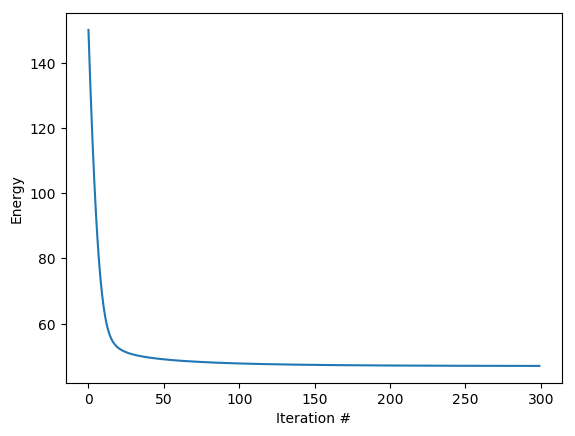

PyObject <matplotlib.text.Text object at 0x00000000277BE898>

In [36]:
include("NtSolutions/inverse_2_deconvolution_variational/exo3.jl")

Display the result.

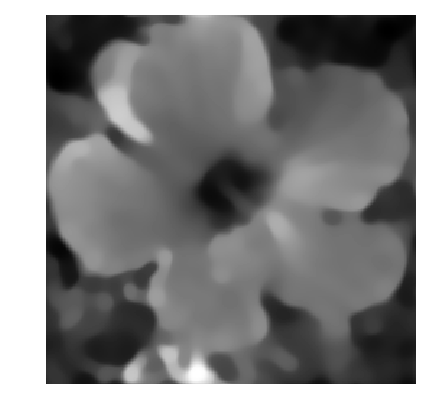

In [37]:
imageplot(clamP(fTV))

### Exercise 4

Explore the different values of |lambda| to find the optimal solution.
Display the SNR as a function of |lambda|.

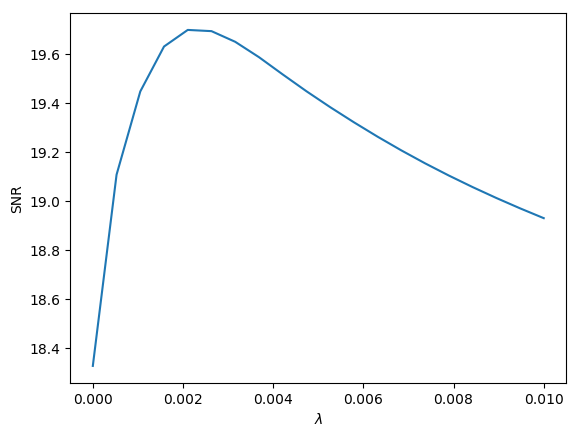

256×256 Array{Float64,2}:
 0.172901  0.184695  0.189334  0.192172  …  0.0550672   0.0911487  0.143912 
 0.146501  0.171049  0.182597  0.188149     0.027206    0.0509994  0.106362 
 0.123126  0.159742  0.17842   0.18647      0.0122972   0.0212409  0.0756531
 0.109446  0.153769  0.177477  0.187861     0.00794715  0.0106811  0.0592337
 0.110437  0.157209  0.181602  0.199191     0.00760048  0.0102725  0.0578393
 0.12786   0.174116  0.212603  0.224344  …  0.00949967  0.0168529  0.0711875
 0.162637  0.229642  0.239075  0.240504     0.0159455   0.03646    0.0963874
 0.213519  0.243945  0.24798   0.248833     0.034717    0.05678    0.128953 
 0.227113  0.24802   0.25198   0.253027     0.0522589   0.0728889  0.154139 
 0.227243  0.249072  0.253659  0.254802     0.0653509   0.0848381  0.158678 
 0.218859  0.246976  0.253587  0.25489   …  0.077123    0.0931501  0.150129 
 0.20009   0.23868   0.251198  0.253374     0.0870894   0.0986414  0.135375 
 0.171752  0.214282  0.241173  0.249576     0.0941

In [38]:
include("NtSolutions/inverse_2_deconvolution_variational/exo4.jl")

Display the result.

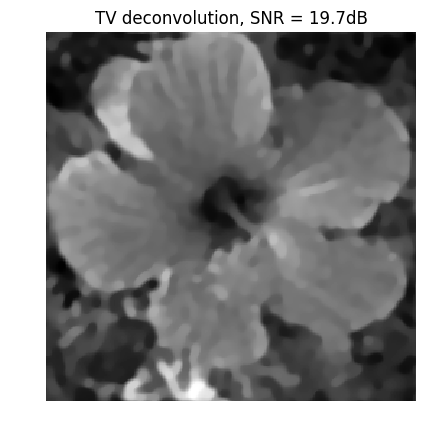

PyObject <matplotlib.text.Text object at 0x000000002A363630>

In [39]:
imageplot(clamP(fBest), string("TV deconvolution, SNR = ", string( round(snr(f0, fBest), 2) ), "dB") )